In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import math
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import clear_output
from typing import Union, Tuple, Dict

# 1.Model Building

### Cleaning Data

In [29]:
df = pd.read_csv('../data/train.csv')
df_t = pd.read_csv('../data/test.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Removing unnecessary columns
df = df.drop(columns=['Id'])

# Drop Columns that have more than 50% of missing values
threshold = 0.5 
columns_to_drop = []

for col in df.columns:
    missing_percentage = df[col].isna().mean()
    if missing_percentage >= threshold:
        columns_to_drop.append(col)

# Drop columns that have value that it's frequency exceeds 90% of the column
threshold = 0.9 * len(df)

for column in df.columns:
    if df[column].value_counts().max() > threshold:
        columns_to_drop.append(column)

df = df.drop(columns=columns_to_drop)

### EDA

In [32]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,548,TA,0,61,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,460,TA,298,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,608,TA,0,42,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,642,TA,0,35,272,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,836,TA,192,84,0,12,2008,WD,Normal,250000


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   Condition1     1460 non-null   object 
 9   BldgType       1460 non-null   object 
 10  HouseStyle     1460 non-null   object 
 11  OverallQual    1460 non-null   int64  
 12  OverallCond    1460 non-null   int64  
 13  YearBuilt      1460 non-null   int64  
 14  YearRemodAdd   1460 non-null   int64  
 15  RoofStyle      1460 non-null   object 
 16  Exterior1st    1460 non-null   object 
 17  Exterior2nd    1460 non-null   object 
 18  MasVnrAr

In [57]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,12.000000,2010.000000,755000.000000


In [35]:
obj = df.select_dtypes(include=['object'])

In [38]:
for col in obj.columns:
    print(f'value count of {col}:\n{obj[col].value_counts()}')
    l = '='*20
    print(f'\n{l}')

value count of MSZoning:
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

value count of LotShape:
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

value count of LandContour:
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

value count of LotConfig:
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64

value count of Neighborhood:
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

value count of Condition1:
Condition1
Norm      1260

/Users/mohamedaminemrabet/miniforge3/envs/deep/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


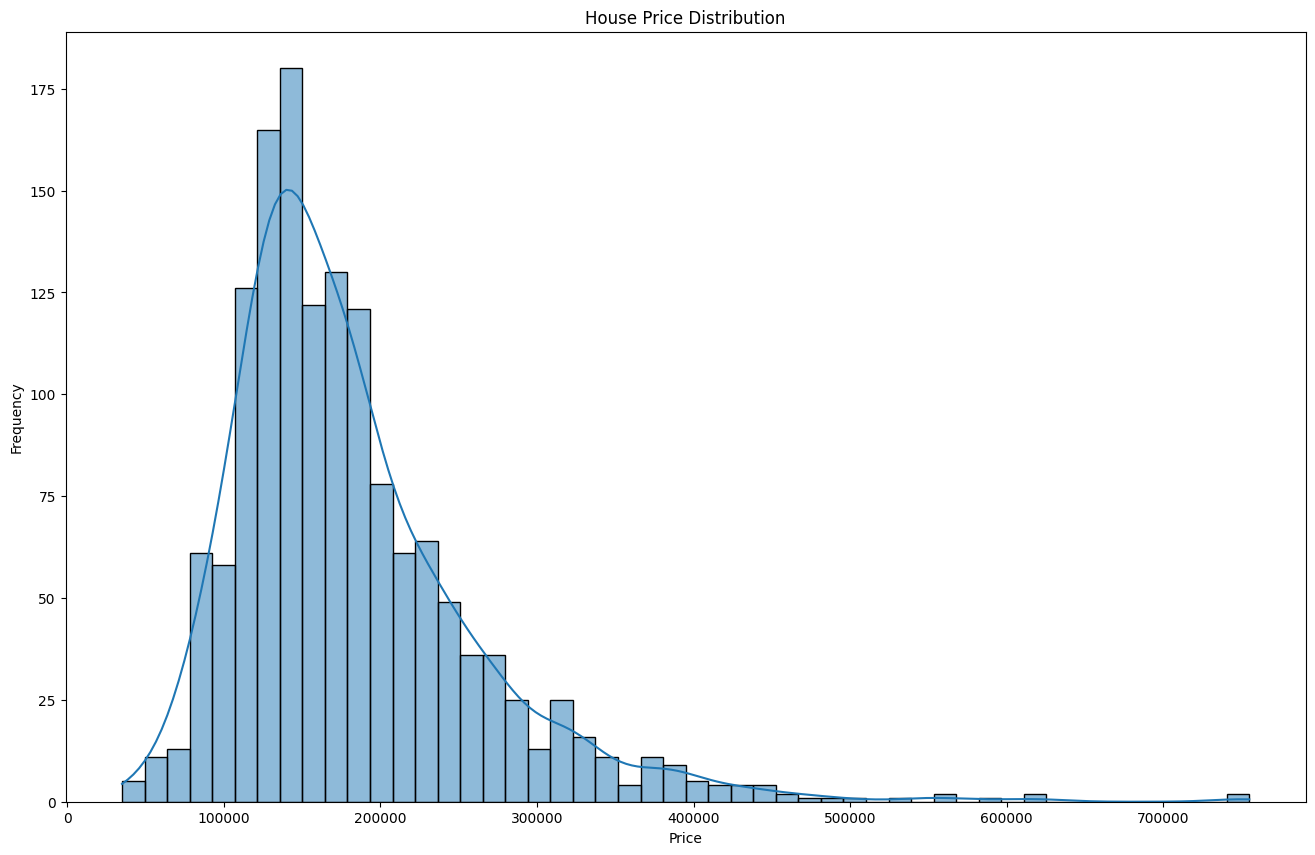

In [46]:
plt.figure(figsize=(16, 10))
sns.histplot(df['SalePrice'], bins=50, kde=True)
plt.title('House Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

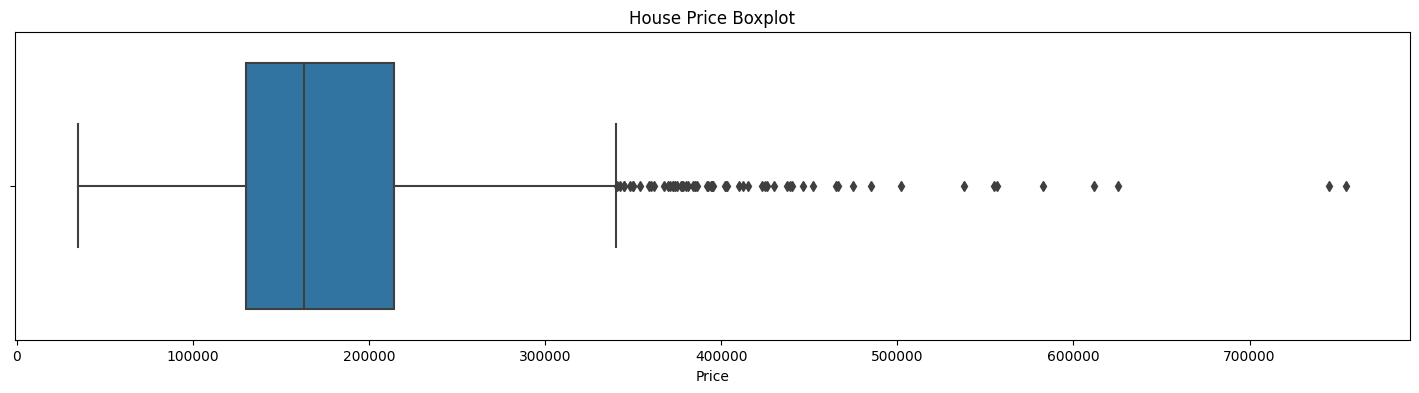

In [51]:
plt.figure(figsize=(18, 4))
sns.boxplot(x=df['SalePrice'])
plt.title('House Price Boxplot')
plt.xlabel('Price')
plt.show()

In [58]:
skewness_pandas = df['SalePrice'].skew()
print("Skewness:", skewness_pandas)

Skewness: 1.8828757597682129


Positive Skewness means that the Distribution is Right-Skewed (Tail on the right side)

In [59]:
from scipy.stats import kurtosis

print("Kurtosis:", kurtosis(df['SalePrice']))

Kurtosis: 6.509812011089439


Kurtosis is a statistical measure that describes the shape of the distribution of data points in a dataset, specifically in terms of the "tailedness" or extremity of values within a distribution. In other words, it tells us whether the data has more or fewer extreme values (outliers) compared to a normal distribution.

### Types of Kurtosis
1. **Mesokurtic:** A distribution with kurtosis close to 0, similar to a normal distribution. It has moderate tails and a similar shape to the Gaussian distribution.

2. **Leptokurtic:** A distribution with positive kurtosis (kurtosis > 0). It has heavy tails, meaning it has more extreme outliers. The distribution is peaked, with data points clustering close to the mean but also many outliers.

3. **Platykurtic:** A distribution with negative kurtosis (kurtosis < 0). It has light tails, meaning it has fewer extreme outliers. The distribution is flatter, with data points more spread out.

In [71]:
correlation_matrix = df.select_dtypes(['int64', 'float64']).corr()
top_corr_features = correlation_matrix['SalePrice'].sort_values(ascending=False)
top_corr_features

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
MoSold           0.046432
BsmtFinSF2      -0.011378
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
Name: SalePrice, dtype: float64

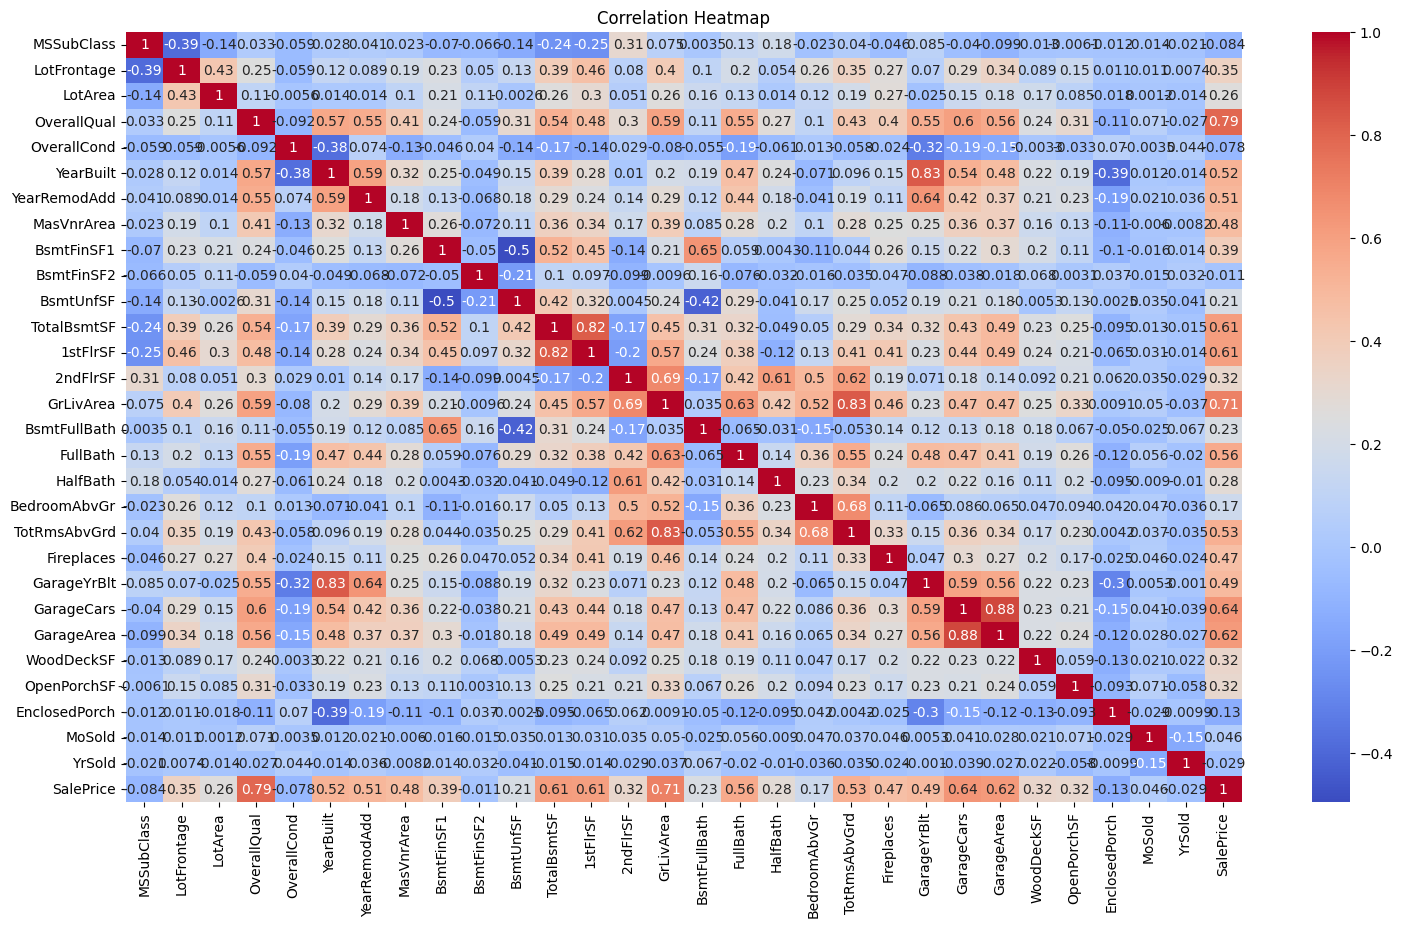

In [67]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.select_dtypes(['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

/Users/mohamedaminemrabet/miniforge3/envs/deep/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


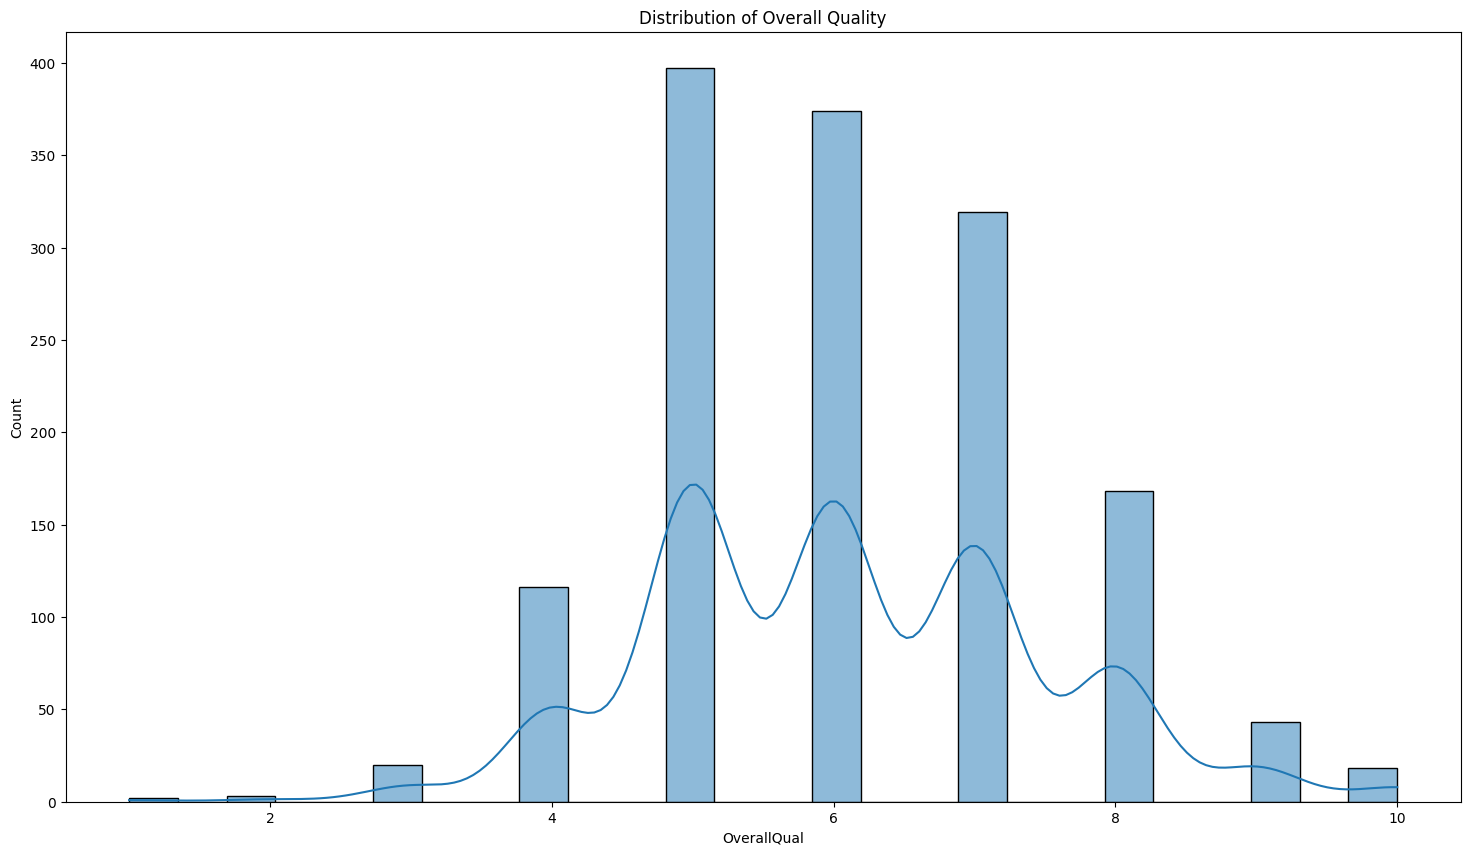

In [79]:
plt.figure(figsize=(18, 10))
sns.histplot(df['OverallQual'],  kde=True)
plt.title('Distribution of Overall Quality')
plt.show()

In [72]:
df['OverallQual'].skew()

0.2169439277628693

In [34]:
df.shape

(1460, 57)

In [33]:
df.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
LotShape           0
LandContour        0
LotConfig          0
Neighborhood       0
Condition1         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
Exterior1st        0
Exterior2nd        0
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinSF1         0
BsmtFinType2      38
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
HeatingQC          0
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
BsmtFullBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Fireplaces         0
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageCars         0
GarageArea   

### Preprocessing

In [4]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ordinal = OrdinalEncoder()

ordinal.fit(X_train.select_dtypes(include = ['object']))

X_train[X_train.select_dtypes(include=['object']).columns] = ordinal.transform(X_train.select_dtypes(include=['object']))

dump(ordinal, '../models/ordinal_encoder.pkl')
dump(X.columns, '../models/columns.pkl')

['../models/columns.pkl']

In [5]:
standard = StandardScaler()

standard.fit(X_train)
X_train = standard.transform(X_train)

dump(standard, '../models/standard_scaler.pkl')

['../models/standard_scaler.pkl']

### Training model

In [6]:
xgb_reg = xgb.XGBRegressor(n_jobs=-1)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
type(xgb_reg)

xgboost.sklearn.XGBRegressor

In [8]:
dump(xgb_reg, '../models/model_before_tuning.pkl')

['../models/model_before_tuning.pkl']

### Model evaluation

In [9]:
X_test[X_test.select_dtypes(include=['object']).columns] = ordinal.transform(X_test.select_dtypes(include=['object']))

X_test = standard.transform(X_test)

In [10]:
y_pred_test = xgb_reg.predict(X_test)
r2score = round(r2_score(y_pred_test,y_test),2) #*100
print("R2 Score on Test Data is :", r2score)

R2 Score on Test Data is : 0.89


In [11]:
mse = mean_squared_error(y_test, y_pred_test)

rmse = round(math.sqrt(mse), 2)

print("rmse Score on Test Data is :", rmse)

rmse Score on Test Data is : 27165.76


In [12]:
def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return print("RMSLE Score on Test Data is :", round(rmsle, precision))

In [13]:
compute_rmsle(y_test, y_pred_test)

RMSLE Score on Test Data is : 0.15


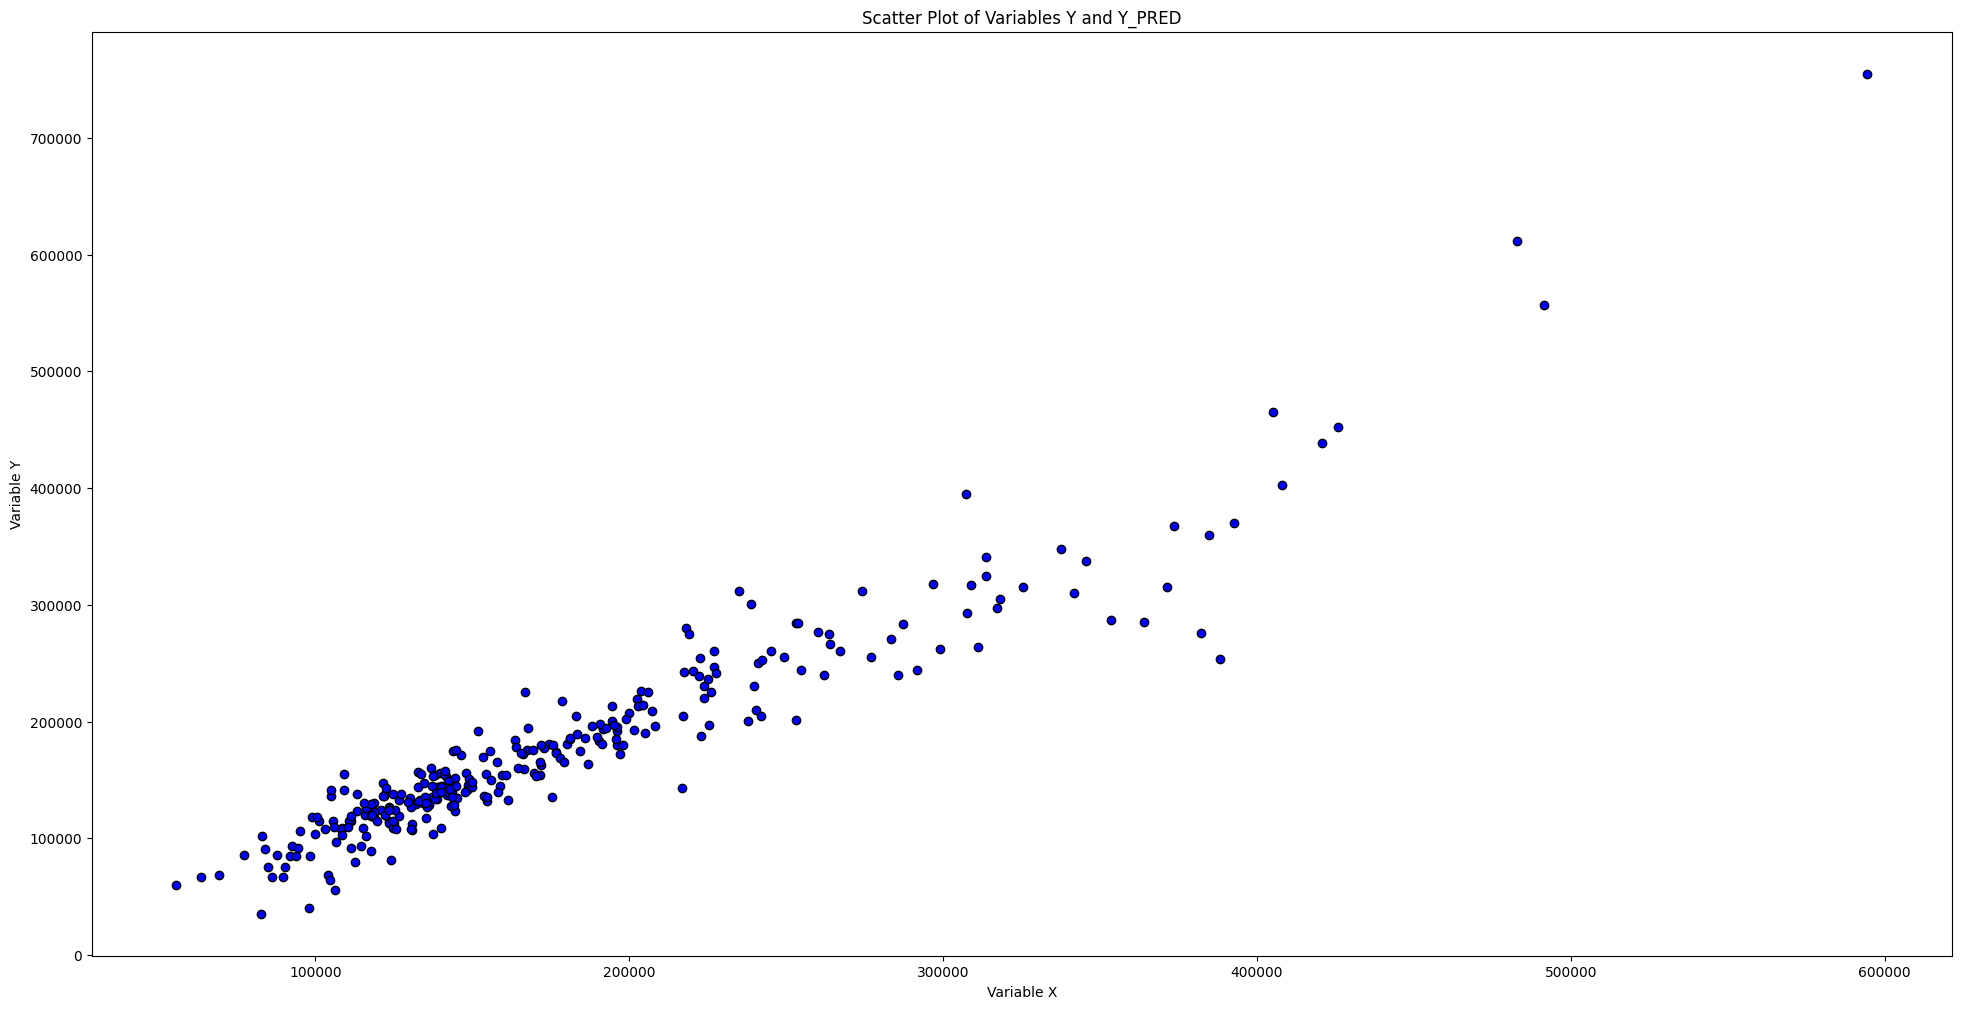

In [14]:
plt.figure(figsize=(24, 12))
plt.scatter(y_pred_test, list(y_test), color='blue', edgecolors='black') #, label=f"Correlation: {correlation:.2f}")
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.title('Scatter Plot of Variables Y and Y_PRED')
# plt.legend()
plt.grid(False)
plt.show()

### Model HyperParameter Tuning

In [15]:
model = load('../models/model_before_tuning.pkl')

In [16]:
params = {
'n_estimators' : [100, 150, 200, 250, 300, 350, 400, 500, 750, 800, 850], # no of trees
'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5], # eta
'min_child_weight': [1, 5, 7, 10],
'gamma': [0.1, 0.5, 1, 1.5, 2, 5],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
'max_depth': [3, 4, 5, 10, 12, 15, 20]
}
folds = 5
param_comb = 100

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=folds, verbose=3, random_state=42)

random_search.fit(X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.04, max_depth=20, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.835 total time=   0.9s
[CV 1/5] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.25, max_depth=20, min_child_weight=7, n_estimators=350, subsample=1.0;, score=0.784 total time=   0.8s
[CV 2/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.04, max_depth=20, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.795 total time=   0.9s
[CV 5/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.04, max_depth=20, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.902 total time=   0.9s
[CV 1/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.04, max_depth=20, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.782 total time=   0.9s
[CV 4/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.04, max_depth=20, min_child_weight=10, n_estimators=500,

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0.1, 0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05, 0.1, 0.25,
                                                          0.5],
                                        'max_depth': [3, 4, 5, 10, 12, 15, 20],
                                        'min_child_weight': [1, 5, 7, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 500,
                                                         750, 800, 850],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=3)

In [17]:
print ('We can get score of :', random_search.best_score_,' using', random_search.best_params_)

We can get score of : 0.8560255111922006  using {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 1.5, 'colsample_bytree': 0.6}


In [18]:
xgb_reg_hpt = xgb.XGBRegressor(subsample = random_search.best_params_['subsample'], n_estimators = random_search.best_params_['n_estimators'], min_child_weight = random_search.best_params_['min_child_weight'], max_depth = random_search.best_params_['max_depth'], learning_rate = random_search.best_params_['learning_rate'], gamma = random_search.best_params_['gamma'], colsample_bytree = random_search.best_params_['colsample_bytree'], n_jobs = -1)
xgb_reg_hpt.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
dump(xgb_reg_hpt, '../models/model.joblib')

['../models/model.joblib']

### Model evaluation after tuning

In [20]:
y_pred_test_hpt = xgb_reg_hpt.predict(X_test)
r2score = round(r2_score(y_pred_test_hpt, y_test),2) #*100
print("R2 Score on Test Data is :", r2score)

R2 Score on Test Data is : 0.9


In [21]:
compute_rmsle(y_test, y_pred_test_hpt)

RMSLE Score on Test Data is : 0.14


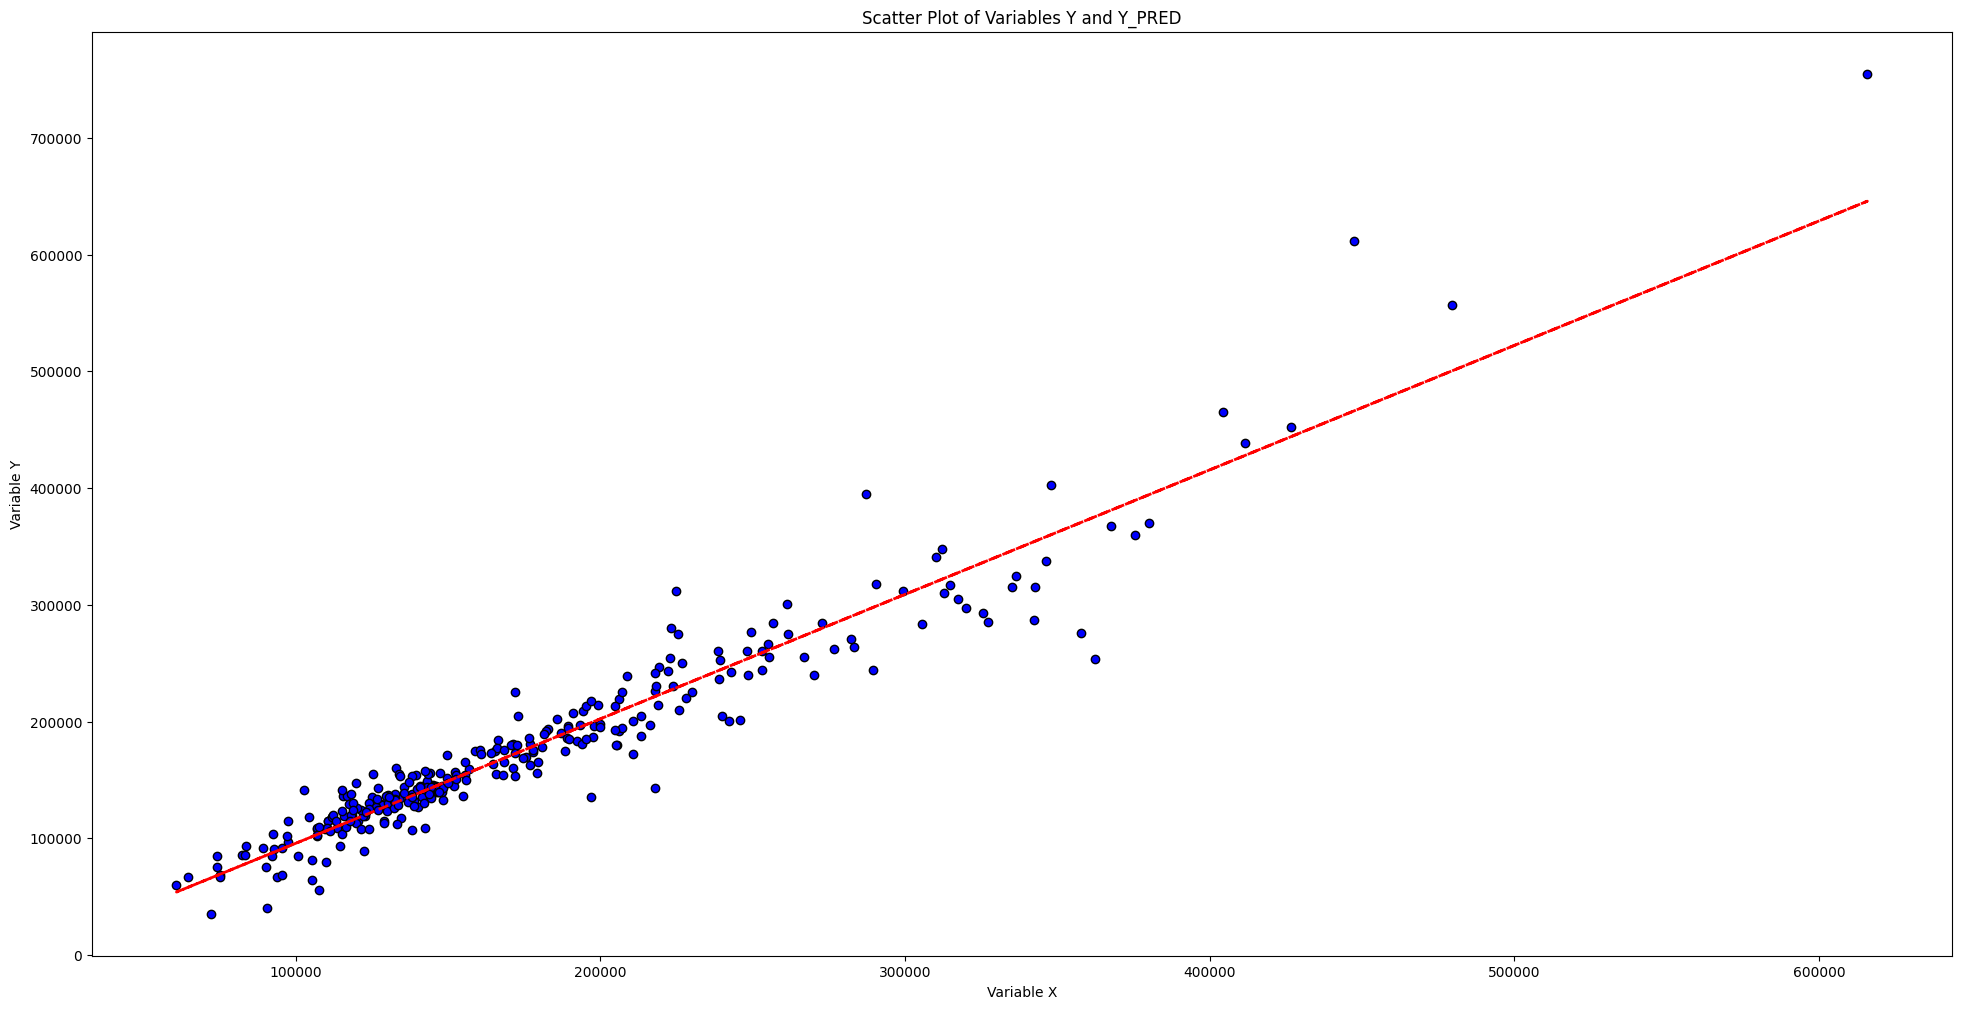

In [22]:
plt.figure(figsize=(24, 12))
plt.scatter(y_pred_test_hpt, list(y_test), color='blue', edgecolors='black') #, label=f"Correlation: {correlation:.2f}")
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.title('Scatter Plot of Variables Y and Y_PRED')
# plt.xlim(0, 100000)
# plt.ylim(0, 100000)

z = np.polyfit(y_pred_test_hpt, y_test, 1)
p = np.poly1d(z)
plt.plot(y_pred_test_hpt, p(y_pred_test_hpt), "r--", linewidth=2, label=f"Trend line: y = {z[0]:.2f}x + {z[1]:.2f}")
plt.grid(False)
plt.show()

# 2.Model inference

In [206]:
df_test = pd.read_csv('../data/test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [207]:
cols = load('../models/columns.pkl')

ids = df_test['Id']
df_test = df_test[cols]

In [ ]:
ordinal = load('../models/ordinal_encoder.pkl')

for index, col in enumerate(df_test.select_dtypes(include=['object']).columns):
    # print(index, col)
    valid = False
    for item in list(set(df_test[col])):
        if item in list(ordinal.categories_[index]):
            valid = True
        else:
            # valid = False
            print(item, ' \nTest array    ', list(set(df_test[col])), '\n\nEncoder array ', ordinal.categories_[index])
            ordinal.categories_[index] = np.append(ordinal.categories_[index], item)
            print('new encoder   ', ordinal.categories_[index], '\n')
            # break
    # print(valid)

    # print(list(set(df_test[i])))


In [209]:
df_test[df_test.select_dtypes(include=['object']).columns] = ordinal.transform(df_test.select_dtypes(include=['object']))

In [210]:
standard = load('../models/standard_scaler.pkl')

df_test = standard.transform(df_test)

In [212]:
model = load('../models/model.joblib')

In [213]:
y_pred = model.predict(df_test)

In [214]:
submission_df = pd.DataFrame({'Id': ids, 'SalePrice': y_pred})
submission_df.to_csv('../data/submission.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.


# 3.code refactoring

### Functions

In [23]:
ScalerType = Union[StandardScaler, MinMaxScaler]

# Constants
MODEL_PATH = '../models/'
DATA_PATH = '../data/'
THRESHOLD_NULL = 0.5
THRESHOLD_COUNT = 0.9


def dropping_null_columns(data: pd.DataFrame, threshold: float = THRESHOLD_NULL) -> pd.DataFrame:
    data = data.drop(columns=['Id'])
    columns_to_drop = [col for col in data.columns if data[col].isna().mean() >= threshold]
    return data.drop(columns=columns_to_drop)


def dropping_unnecessary_columns(data: pd.DataFrame, threshold: float = THRESHOLD_COUNT) -> pd.DataFrame:
    columns_to_drop = [col for col in data.columns if data[col].value_counts().max() > threshold * len(data)]
    return data.drop(columns=columns_to_drop)


def ordinal_encoding(X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    ordinal = OrdinalEncoder()
    categorical_columns = X_train.select_dtypes(include=['object']).columns

    ordinal.fit(X_train[categorical_columns])
    X_train[categorical_columns] = ordinal.transform(X_train[categorical_columns])
    X_test[categorical_columns] = ordinal.transform(X_test[categorical_columns])

    dump(ordinal, MODEL_PATH + 'ordinal_encoder.pkl')
    dump(X.columns, MODEL_PATH + 'columns.pkl')

    return X_train, X_test, y_train, y_test


def standardizing(X_train: pd.DataFrame, X_test: pd.DataFrame, scaler: ScalerType) -> Tuple[np.ndarray, np.ndarray]:
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    dump(scaler, MODEL_PATH + 'standard_scaler.pkl')

    return X_train, X_test


def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return round(rmsle, precision)


def evaluation(model: xgb.XGBRegressor, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    y_pred_test = model.predict(X_test)
    return {
        'R2': round(r2_score(y_test, y_pred_test), 2),
        'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2),
        'rmsle': compute_rmsle(y_test, y_pred_test)
    }


def build_model_before_tuning(data: pd.DataFrame) -> Tuple[xgb.XGBRegressor,
                                                           np.ndarray, np.ndarray,
                                                           np.ndarray, np.ndarray]:
    data = dropping_null_columns(data)
    data = dropping_unnecessary_columns(data)
    X = data.drop(columns=['SalePrice'])
    y = data['SalePrice']
    X_train, X_test, y_train, y_test = ordinal_encoding(X, y)
    X_train, X_test = standardizing(X_train, X_test, StandardScaler())

    xgb_reg = xgb.XGBRegressor(n_jobs=-1)
    xgb_reg.fit(X_train, y_train)
    dump(xgb_reg, MODEL_PATH + 'model_before_tuning.joblib')

    return xgb_reg, X_train, X_test, y_train, y_test


def encode_and_update(data: pd.DataFrame, ordinal_path: str) -> OrdinalEncoder:
    ordinal = load(ordinal_path)
    categorical_columns = data.select_dtypes(include=['object']).columns

    for index, col in enumerate(categorical_columns):
        unique_items = set(data[col])
        known_items = set(ordinal.categories_[index])
        new_items = unique_items - known_items

        if new_items:
            ordinal.categories_[index] = np.append(ordinal.categories_[index], list(new_items))

    dump(ordinal, MODEL_PATH + 'ordinal_encoder.pkl')
    return ordinal


def load_pkls() -> Tuple[pd.Index, ScalerType, xgb.XGBRegressor]:
    cols = load(MODEL_PATH + 'columns.pkl')
    standard = load(MODEL_PATH + 'standard_scaler.pkl')
    model = load(MODEL_PATH + 'model.joblib')
    return cols, standard, model


def make_prediction_before_tuning(data: pd.DataFrame) -> str:
    cols, standard, model = load_pkls()
    ids = data['Id']
    df_test = data[cols]
    ordinal = encode_and_update(df_test, MODEL_PATH + 'ordinal_encoder.pkl')

    df_test[df_test.select_dtypes(include=['object']).columns] = ordinal.transform(
        df_test.select_dtypes(include=['object']))
    df_test = standard.transform(df_test)

    y_pred = model.predict(df_test)
    submission_df = pd.DataFrame({'Id': ids, 'SalePrice': y_pred})
    submission_df.to_csv(DATA_PATH + 'submission.csv', index=False)

    return "Submission file created successfully."


def tuning(model: xgb.XGBRegressor, X_train: np.ndarray,
           X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    params = {
        'n_estimators': [100, 150, 200, 250, 300, 350, 400, 500, 750, 800, 850],
        'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5],
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5, 10, 12, 15, 20]
    }
    folds = 5
    param_comb = 100

    random_search = RandomizedSearchCV(model, param_distributions=params,
                                       n_iter=param_comb, n_jobs=-1,
                                       cv=folds, verbose=3,
                                       random_state=42)
    random_search.fit(X_test, y_test)

    best_params = random_search.best_params_
    xgb_reg_hpt = xgb.XGBRegressor(
        subsample=best_params['subsample'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        gamma=best_params['gamma'],
        colsample_bytree=best_params['colsample_bytree'],
        n_jobs=-1
    )
    xgb_reg_hpt.fit(X_train, y_train)
    clear_output(wait=False)
    dump(xgb_reg_hpt, MODEL_PATH + 'model.joblib')

    return {'model performance after tuning': evaluation(xgb_reg_hpt, X_test, y_test)}


In [24]:
def build_model(data: pd.DataFrame) -> Tuple[Dict[str, float], Dict[str, float]]:
    model, X_train, X_test, y_train, y_test = build_model_before_tuning(data)

    return ({'model performance before tuning': evaluation(model, X_test, y_test)},
            tuning(model, X_train, X_test, y_train, y_test))


def make_prediction(data: pd.DataFrame) -> pd.DataFrame:
    cols, standard, model = load_pkls()

    ids = data['Id']
    df_test = data[cols]
    ordinal = encode_and_update(df_test, MODEL_PATH + 'ordinal_encoder.pkl')
    df_test[df_test.select_dtypes(include=['object']).columns] = ordinal.transform(
        df_test.select_dtypes(include=['object']))
    
    df_test = standard.transform(df_test)

    y_pred = model.predict(df_test)
    submission_df = pd.DataFrame({'Id': ids, 'SalePrice': y_pred})
    submission_df.to_csv('../data/submission.csv', index=False)
    clear_output(wait=False)
    print("Submission file created successfully.")

    return submission_df


### Testing Functions

In [25]:
df = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [26]:
build_model(df)

({'model performance before tuning': {'R2': 0.9,
   'rmse': 27165.76,
   'rmsle': 0.15}},
 {'model performance after tuning': {'R2': 0.92,
   'rmse': 25387.49,
   'rmsle': 0.14}})

In [27]:
make_prediction(df_test)

Submission file created successfully.


,Id,SalePrice
0,1461,123926.289062
1,1462,153378.062500
2,1463,183990.140625
3,1464,190058.343750
4,1465,193734.453125
...,...,...
1454,2915,83885.117188
1455,2916,89570.804688
1456,2917,185223.546875
1457,2918,121526.164062
